[En français](../use-case-oafeat-en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python

# Use case: Tracking water level with GeoMet-OGC-API

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON file can than be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with [Python](https://www.python.org/)
* Process time series data to obtain descriptive statistics for a chosen temporal unit
* Display time series data in graphic and tabular format
* Create an interactive map to display geospatial data

An [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=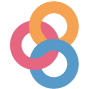)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

## Creation of a tool to track water level 

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water level of a few hydrometric stations near her city to guide the management of the company activities. She would like to have:
* The daily water level of the past 3 months for all hydrometric stations located within 100 km of the city of Chilliwack
* Graphic and tabular views that present the provisional daily mean water level of the past 3 months
* A web map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Modules importation
from datetime import date
import json
from textwrap import fill

from dateutil.relativedelta import relativedelta
from ipyleaflet import (
    AwesomeIcon,
    basemaps,
    FullScreenControl,
    Map,
    Marker,
    ScaleControl,
    WidgetControl,
)
from ipywidgets import HTML, interact
from matplotlib import pyplot as plt, dates as mdates
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd

In [2]:
# Parameters

# Coordinates
lat = 49.162676
long = -121.958943

# Buffer size in kilometers
buffer = 100

# Number of months used to analyse historical data
num_months = 3

# ESPG code of the prefered projection to create the buffer
# NAD83 / Statistics Canada Lambert
projection = 3347

In [3]:
# Parameters formatting for the OGC API - Features request

# Bounding box a little bigger than buffer size (1 km ≈ 0.01°)
bbox = [
    str(long - buffer * 0.01),
    str(lat - buffer * 0.01),
    str(long + buffer * 0.01),
    str(lat + buffer * 0.01),
]

# Time
end_date = date.today()
end_date = date(2018, 12, 31)  # Available data to test the code
start_date = end_date - relativedelta(months=num_months)
time = f'{start_date.strftime("%Y-%m-%d")}/{end_date}'

Than, the [hydrometric monitoring stations data](https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations) available on GeoMet-OGC-API can be retrieved with the [OWSLib package](https://geopython.github.io/OWSLib/). As the bounding box parameter is not as precise as a round buffer, [GDAL](https://gdal.org/api/index.html#python-api) can be used to select only the hydrometric stations that are strictly inside a 100 km radius from Chilliwack.

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features("https://geo.weather.gc.ca/geomet/features")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Verification of the retrieved data
if "features" in station_data.keys() and station_data["features"]:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No hydrometric stations were found. Please verify the coordinates."
    )

In [5]:
# List of stations located inside the buffer zone

# Accessing the hydrometric stations layer
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification of the input spatial reference system (srs)
srs_input = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srs_input))
epsg = sr.GetAuthorityCode(None)
srs_input.ImportFromEPSG(int(epsg))

# Definition of the srs used to project data
srs_projected = osr.SpatialReference()
srs_projected.ImportFromEPSG(projection)

# Transformation from input srs to the prefered projection
transform = osr.CoordinateTransformation(srs_input, srs_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

# Raising an error if no station were found
if not stations:
    raise ValueError(
        f"There are no hydrometric stations within {buffer} km"
        + " of the chosen coordinates. Please verify the coordinates."
    )

Once the hydrometric monitoring stations located within 100 km of Chilliwack are identified, the water level data of the past three months can be retrieved for each station. The provisional daily mean water level will than be calculated for each day of the 3 months period.

The provisional daily mean water level of the past 3 months will be used to create a data frame of the historical daily water level for each station with [Pandas](https://pandas.pydata.org/). To facilitate the data manipulations, all the data frames will be gathered in a Python dictionary. These data frames will be used to create an interactive graphic and tabular view of the historical daily water level of the hydrometric monitoring stations located within 100 km of Chilliwack. The most recent provisional daily mean water level of all the stations will also be compiled in a single data frame that will be used to display the most recent water level data on an interactive map.

Stations that do note have water level data available in the desired time period or for the current date will be removed from the dataset.

In [6]:
# Retrieval of hydrometric data for each station

# Dictionary that will contain a data frame for each station
# with the historical daily water level for the time period
hydrometric_data = {}

# List of stations with missing data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        time=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Creation of a dataframe if there is data for the chosen time period
    if hydro_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Creation of the dataframe
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Adding the dataframe to the hydrometric data dictionary
        if not historical_data_df["LEVEL"].isnull().all():
            # Removing any rows without water level data at the
            # end of the dataframe
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Creating an index with the date in a datetime format
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            # Adding the dataframe to the dictionary
            hydrometric_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing hydrometric stations with insufficient data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
if not stations:
    raise ValueError(
        f"No water level data is available in the last {num_months}"
        + " months for the selected hydrometric stations."
    )

Now that all the data frames are ready, the data can be visualized in a graphic view. Pandas can be used to generate interactive plots on Jupyter Notebook with the [Plotly backend](https://plotly.com/python/pandas-backend/). A dropdown menu can be added in Jupyter Notebook with ipywidget to select the desired hydrometric monitoring station.

<IPython.core.display.Javascript object>


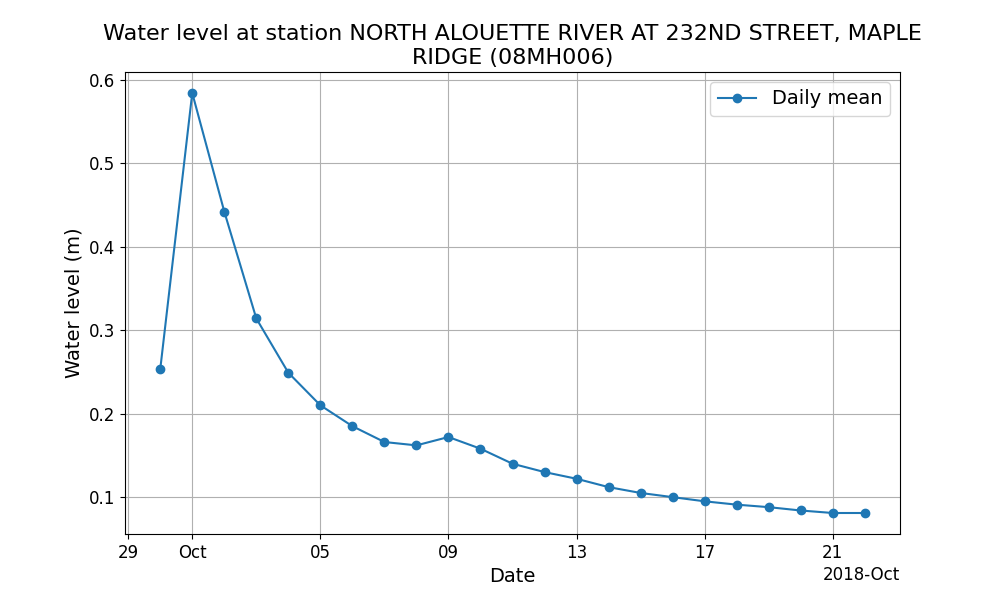

In [7]:
# Creation of an interactive plot with Pandas and Matplotlib

# Remove the magic command to use out of Jupyter Notebook
%matplotlib notebook

# Function to show the plot of the chosen hydrometric station
def interactive_plot(station):
    # Creation of the plot
    params = {'legend.fontsize': '14',
              'figure.figsize': (10, 6),
              'axes.labelsize': '14',
              'axes.titlesize': '16',
              'xtick.labelsize': '12',
              'ytick.labelsize': '12'}
    plt.rcParams.update(params)

    fig, ax = plt.subplots()
    line, = plt.plot(
        hydrometric_data[station].index,
        hydrometric_data[station]["LEVEL"],
        marker='o',
        label="Daily mean"
    )
    plt.legend()
    plt.grid(True, which='both')

    ax.set_title(fill(
        "Water level at station {} ({})".format(
            hydrometric_data[station]["STATION_NAME"][0], station
        )
    ))
    ax.set_ylabel("Water level (m)")
    ax.set_xlabel("Date")

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    annot = ax.annotate("", xy=(0,0), xytext=(-60,-40), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    
    return line, annot, ax, fig

line, annot, ax, fig = interactive_plot(stations[8])


def update_annot(ind):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    date_x = x[ind["ind"]][0].astype('datetime64[D]')
    level_y = round(y[ind["ind"]][0], 2)
    text = "{}\nDaily mean: {} m".format(date_x, level_y)
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.8)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

A similar dropdown widget can be used to select which hydrometric monitoring station data to show in the interactive data table.

In [8]:
# Creation of the table

# Option to show all rows
pd.set_option("max_rows", None)


# Function to show the table of the chosen hydrometric station
def data_table(station):
    # Print table title
    print(
        f"Water level at station "
        + f"{hydrometric_data[station]['STATION_NAME'][0]}"
        + f" ({station})"
    )
    # Selecting the desired columns and changing the columns names
    displayed_df = hydrometric_data[station][["LEVEL"]].rename(
        columns={
            "LEVEL": "Water level daily mean (m)",
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    return displayed_df

data_table(stations[8])

Water level at station NORTH ALOUETTE RIVER AT 232ND STREET, MAPLE RIDGE (08MH006)


,Water level daily mean (m)
Date,
2018-09-30,0.253
2018-10-01,0.584
2018-10-02,0.442
2018-10-03,0.314
2018-10-04,0.249
2018-10-05,0.210
2018-10-06,0.185
2018-10-07,0.166
2018-10-08,0.162


Finally, an interactive map can be created with ipyleaflet to display the most recent water level daily mean of all the hydrometric monitoring stations located within 100 km of Chilliwack.

In [9]:
# Creation of the interactive map

# Latitude at the center of the station points (to center map)
latitudes = [hydrometric_data[station]["LATITUDE"][0] for station in stations]
center_lat = (min(latitudes) + max(latitudes)) / 2

# Parameters
center = [center_lat, long]
zoom = 8

# Map
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Adding hover information
html = HTML("Hover over Hydrometric Stations")
html.layout.margin = "0px 10px 10px 10px"
control = WidgetControl(widget=html, position="topright", max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = (
            f"<b>{hydrometric_data[station]['STATION_NAME'][0]}</b><br>"
            + f"Station ID: {marker.STATION_NUMBER}<br>"
            + f"Timestamp: {marker.name}<br>"
            + f"Water level: {round(marker.LEVEL, 2)} m"
        )

    return callback


# Adding scale and full screen control
m.add_control(ScaleControl(position="bottomleft"))
m.add_control(FullScreenControl())

# Adding a marker to the map for each hydrometric station
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    icon = AwesomeIcon(name="tint", marker_color="darkblue")
    station_marker = Marker(
        icon=icon,
        location=[latest_data.LATITUDE, latest_data.LONGITUDE],
        draggable=False,
    )
    station_marker.on_mouseover(get_callback(latest_data))
    m.add_layer(station_marker)

# Display the map
display(m)

Map(center=[49.110361099243164, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

## Conclusion

Cathy has now a good overview of the water level of the bodies of water near her. This information will help her plan her boat tours and water sports company activities. After completing this use case, you should be able to use Python to retrieve geospatial data from GeoMet-OGC-API, to calculate descriptive statistics for the temporal units of your choice for a time series and to display data in different interactive format (plot, table and web map). This use case can be adapted to fit your needs by changing the parameters or modifying the data processing steps.